In [2]:
%matplotlib inline
import io, os, copy
import numpy as np
from scipy import fftpack
import scipy.sparse.linalg as spli
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import KFold

from defaults import *

data directory /media/martin/Projects/QA4ECV_ATBD-master/data


In [3]:
def monotonic(x):
    dx = np.diff(x)
    return np.all(dx <= 0) or np.all(dx >= 0)

This notebook has the following sections:

Define some functions, that are used to form A and b matrices and solving x and y_hat

Loading the datasets

An example, simple example to demonstrate the solver function

Pooling data, from multiple satelites

Tuning gamma_day and gamma_year

**NOTE:** HeadingsMap as an add-on to Firefox (or similar plug-in for other browsers) may provide the appreciable functionality of indexing the headings of this notebook into a Table of Contents, shown in a side-panel of the browser...

# Define some functions

These ones are for forming the $A$ and $b$ matrices and solving for the state vector, $x$, and predicting $\hat{y}$.

In [4]:
def form_observation_matrices(dataset, ndays, ignore_weight=False):
    """
    dataset.keys = 'refl', 'weight', 'kernels', 'idoy', 'date', 'year', 'doy'
    Note: idoy is more like a day counter, that counts days since the
    baseline, i.e. day_0 and exceeds 365 (or 366) for multi-year datasets.
    """
    # get some counts of sorts...
    nk, nbands, nsamp = dataset['kernels'].shape
    steps = nbands * nk
    
    # create sparse matrices
    bigshape = tuple(np.array([ndays, ndays]) * nk * nbands)
    A_o = scipy.sparse.lil_matrix(bigshape)
    b_o = scipy.sparse.lil_matrix((bigshape[0],1))
    
    # alias some variables for legibility
    refl = dataset['refl']
    kernels = dataset['kernels']
    weight = dataset['weight']
    
    # load into A and b matrices, every day is a 9x9 block along
    # the diagonal of A and a series of 9 elements along b (=vector)
    for i in xrange(nsamp):
        R_i = np.matrix(refl[...,i]).T
        k33 = np.matrix(kernels[...,i]).T # k33 has shape (3 x 3), but we need (3 x 9)
        if ignore_weight:
            W_i = np.eye(3) # there might be an issue with the weight matrices, this ignore-option is for debugging...
        else:
            W_i = np.matrix(weight[...,i])
        thisdoy = dataset['idoy'][i]
        
        # load k33 into its 3 x 9 matrix
        K_i = np.matrix(np.zeros((nbands,nbands*nk)))
        for j in xrange(nbands): K_i[j,j*nk:(j+1)*nk] = k33[j]
        
        KR_i = K_i.T * W_i * R_i
        KK_i = K_i.T * W_i * K_i
        sli = slice(thisdoy*steps, (thisdoy+1)*steps)
        
        # add ie accumulate in case of multiple samples per day
        try:
            A_o[sli,sli] += KK_i
            b_o[sli,0] += KR_i
        except:
            print "ERROR in forming observations matrix", i, '>>-->', sli
    
    return A_o, b_o

In [5]:
def form_regularisation_matrices(gamma_day, gamma_year, ndays, nk, nbands):
    # form a D matrix for days -- should replace by sparse
    I = np.eye(ndays)
    D = np.matrix(I - np.roll(I,-1))
    D1 = D * D.T

    # form a D matrix for years -- should replace by sparse
    D = np.matrix(I - np.roll(I,-365))
    D365 = D * D.T
    
    bigshape = tuple(np.array([ndays, ndays]) * nk * nbands)
    A_D = scipy.sparse.lil_matrix(bigshape)
    A_D365 = scipy.sparse.lil_matrix(bigshape)
    
    steps = nbands * nk
    for i in xrange(steps):
        A_D[i::steps, i::steps] = D1
        A_D365[i::steps, i::steps] = D365
    
    A_d = gamma_day * (A_D.T * A_D)
    A_y = gamma_year * (A_D365.T * A_D365)

    return A_d, A_y

Currently priors are not implemented yet, so the code has been commented out. In fact, one of the objectives is to see whether the state vector can be estimated without any priors, but - I guess - for comparision we would need a prior-inclusive version of the algorithm.

In [6]:
# def form_prior_matrices(prior, ndays, bands=['VIS', 'NIR', 'SW'], nk=3, nsamp=46, scale=1.0):
#     """
#     prior: e.g. select keys 'prior.v2.snow' or 'prior.v2.nosnow' in ncdata
#     day_0: baseline date
#     ndays: number of days from baseline (day_0) until last day of inferred state vector
#     nsamp: equals 46 if prior is sampled every 8 days over one year
#     scale: not sure why this was used... save to keep at one.
#     """
#     nbands = len(bands)
    
#     # mean
#     mean = []
#     for b in bands:
#         m = np.array(prior['Mean_%s'%b]).squeeze().reshape(nk,nsamp)
#         mean.append(m)
#     mean = np.array(mean)
#     print mean.shape

#     # var -> weight
#     kk = ['f%d'%i for i in xrange(nk)]
#     var = [[]]*nbands
#     for band in xrange(nbands):
#         var[band] = []
#         for p,f0 in enumerate(kk):
#             cc = np.array(prior['Cov_%s_%s_%s_%s'%(bands[band],f0,bands[band],f0)]).squeeze()
#             var[band].append(cc)  
#     var = np.array(var)
#     weight = 1./var
#     weight = weight/scale
    
#     # these are formed 
#     xp = np.zeros((nbands*nk*ndays))
#     Wp = np.zeros((nbands*nk*ndays))
    
#     for d in xrange(ndays):
#         thisday = day_0 + timedelta(d)
#         thisprior = ((thisday - date(thisday.year,1,1)).days)/8
#         for k in xrange(nk): 
#             xp[d*nbands*nk+k*nbands:d*nbands*nk+(k+1)*nbands] = mean[:,k,thisprior]
#             Wp[d*nbands*nk+k*nbands:d*nbands*nk+(k+1)*nbands] = weight[:,k,thisprior]
#     A_p = scipy.sparse.lil_matrix(scipy.sparse.diags(Wp,0))
#     b_p = A_p * scipy.sparse.lil_matrix(xp).T

#     return A_p, b_p


Reminder: the prior isn't used in the function below

In [7]:
def compute_state_vector(dataset, gamma_day, gamma_year, ndays=None, \
                         ignore_weight=False, do_unc=False):
    if ndays == None:
        ndays = dataset['idoy'][-1]+1
    assert np.all( [i >= 0 and i <= ndays for i in dataset['idoy']] )
    
    nk, nbands, _ = dataset['kernels'].shape
    
    # form A & b matrices
    A_o, b_o = form_observation_matrices(dataset, ndays, ignore_weight=ignore_weight)
    A_d, A_y = form_regularisation_matrices(gamma_day, gamma_year, ndays, nk, nbands)
#    A_p, b_p = form_prior_matrices(priordata, ndays, \
#                                    bands=['VIS', 'NIR', 'SW'], nk=3, nsamp=46, scale=1.0)
    
    # solve for state vector
    A = (A_o + A_d + A_y).tocsc()
    b = b_o.tocsc()
    x = spli.spsolve(A, b, use_umfpack=True)
    if do_unc:
        post_cov = 1.0 / A.diagonal()
        return x, post_cov
    else:
        return x # order f0(VIS), f1(VIS), f2(VIS), f0(NIR), f1(NIR), f2(NIR), f0(SW), f1(SW), f2(SW), ...repeated for ndays

In [8]:
def compute_y_hat(dataset, x):
    """
    Estimate BBDR reflectance in VIS, NIR and SW bands given a state vector
    """
    nk, nbands = dataset['kernels'].shape[:2]
    idoys = dataset['idoy']
    nobs = idoys.size

    # fetch states for idoy...
    idxs = np.zeros(nobs*nk*nbands, dtype=int)
    for i, idoy in enumerate(idoys):
        sli = slice(i*nk*nbands, (i+1)*nk*nbands)
        rng = range(idoy*nk*nbands, (idoy+1)*nk*nbands)
        idxs[sli] = rng # maps to: f0(VIS), f1(VIS), f2(VIS), f0(NIR), f1(NIR), f2(NIR), f0(SW), f1(SW), f2(SW)
    x_idoy = x[idxs] # state vector arranged by order (w/ duplication!) of observations
    
    # define K matrix that matches the order of idoy...
    K_idoy = np.zeros((nbands*nobs, nbands*nk*nobs), dtype=float)
    for i, idoy in enumerate(idoys):
        dim0 = i*nbands # top-left of this block of 3 rows x 9 columns
        dim1 = i*nbands*nk # top-left of this block of 3 rows x 9 columns
        for j in range(nbands):
            for jj in range(nk):
                # (ncdata[sensor]['kernels'] =) dataset['kernels'] has shape: [nk, nbands, ndoys]
                K_idoy[dim0+j, dim1+(j*3)+jj] = dataset['kernels'][jj,j,i]
    
    y_hat_vector = np.matrix(K_idoy) * np.matrix(x_idoy).T
    y_hat = y_hat_vector.reshape(nobs, nbands).T
    y_hat = np.asarray(y_hat)
    return y_hat

In [9]:
def plot_state_vector(dataset, x, xmin=0, xmax=5000, ymin=-1.0, ymax=1.0, post_cov=None):
    first_day = dataset['date'][0]
    ndays = dataset['idoy'][-1]+1
    nk, nbands, nobs = dataset['kernels'].shape
    step = nk * nbands
    day_range = np.arange(ndays)
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    idoys = dataset['idoy']
    
    if post_cov != None:
        ax1.fill_between(day_range,  x[0::step]-post_cov[0::step], x[0::step]+post_cov[0::step], color="0.8")
        ax1.fill_between(day_range,  x[3::step]-post_cov[3::step], x[3::step]+post_cov[3::step], color="0.8")
        ax1.fill_between(day_range,  x[6::step]-post_cov[6::step], x[6::step]+post_cov[6::step], color="0.8")
        
        ax2.fill_between(day_range,  x[1::step]-post_cov[1::step], x[1::step]+post_cov[1::step], color="0.8")
        ax2.fill_between(day_range,  x[4::step]-post_cov[4::step], x[4::step]+post_cov[4::step], color="0.8")
        ax2.fill_between(day_range,  x[7::step]-post_cov[7::step], x[7::step]+post_cov[7::step], color="0.8")
        
        ax3.fill_between(day_range,  x[2::step]-post_cov[2::step], x[2::step]+post_cov[2::step], color="0.8")
        ax3.fill_between(day_range,  x[5::step]-post_cov[5::step], x[5::step]+post_cov[5::step], color="0.8")
        ax3.fill_between(day_range,  x[8::step]-post_cov[8::step], x[8::step]+post_cov[8::step], color="0.8")

    
    # order of elements in x: f0(VIS), f1(VIS, f2(VIS), f0(NIR), ..., f2(SW) repeated for ndays
    ax1.plot(day_range, x[0::step], label='f0(VIS)')
    ax1.plot(day_range, x[3::step], label='f0(NIR)')
    ax1.plot(day_range, x[6::step], label='f0(SW)')
    ax1.plot(idoys, np.ones_like(idoys)*ymin, 'k+')
    ax1.legend()
    ax1.set_xlim((xmin, xmax))
    ax1.set_ylim((ymin, ymax))
    
    ax2.plot(day_range, x[1::step], label='f1(VIS)')
    ax2.plot(day_range, x[4::step], label='f1(NIR)')
    ax2.plot(day_range, x[7::step], label='f1(SW)')
    ax2.plot(idoys, np.ones_like(idoys)*ymin, 'k+')
    ax2.legend()
    ax2.set_xlim((xmin, xmax))
    ax2.set_ylim((ymin, ymax))
    
    ax3.plot(day_range, x[2::step], label='f2(VIS)')
    ax3.plot(day_range, x[5::step], label='f2(NIR)')
    ax3.plot(day_range, x[8::step], label='f2(SW)')
    ax3.plot(idoys, np.ones_like(idoys)*ymin, 'k+')
    ax3.legend()
    ax3.set_xlim((xmin, xmax))
    ax3.set_ylim((ymin, ymax))
    
    return

# Load the datatsets

In [10]:
# load up the datasets we want
# 
# Mostly, this is the Ab data at this point
# but we will also load v3.0 or v2.0 data for support
#

datakeys = np.array(['bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])

# load the datasets into a dictionary in ncdata
ncdata = {}
abdata = {}
for k in datakeys:
    try:
        abdata[k] = load_obj('obj/' + k + '_Ab_' )
        print '\nAb',k,
    except:
        pass
    try:
        ncdata[k] = load_obj('obj/' + k + '_s3.0_' )
        print '\n\t3',k,
    except:
        ncdata[k] = load_obj('obj/' + k + '_s2.0_' )
        print '\n\t\t2',k,
        
        
nbands, nk = ncdata['mod09']['kernels'].shape[0:2]
nskip = nbands *nk



Ab bbdr.meris 
	3 bbdr.meris 
Ab bbdr.vgt 
	3 bbdr.vgt 
		2 ga.brdf.merge 
		2 ga.brdf.nosnow 
		2 ga.brdf.snow 
Ab mod09 
	3 mod09 
Ab myd09 
	3 myd09 
Ab prior.v2.nosnow 
		2 prior.v2.nosnow 
Ab prior.v2.snow 
		2 prior.v2.snow 
		2 prior.v2.snownosnow


REMINDER: Note I am not using 'year' and 'doy' keys, I will leave them in, but copies/modifications of ncdata or subdatasets thereof may not contain 'year' and 'doy', and I interpret 'idoy' as being the day number after our baseline, and does not necessarily have to be January 1st. Also, 'date' may/will likely get screwed up along the processing path. I have to fix this, but I wanted to avoid having to use and maintain 4 different date-like fields.

In [10]:
for sensor in ['bbdr.meris', 'bbdr.vgt', 'mod09', 'myd09']:
    print sensor, 'idoy', ncdata[sensor]['idoy'].shape
    print sensor, 'date', ncdata[sensor]['date'].shape
    print sensor, 'kernels', ncdata[sensor]['kernels'].shape
    print sensor, 'weight', ncdata[sensor]['weight'].shape
    print sensor, 'refl', ncdata[sensor]['refl'].shape
    print ''

bbdr.meris idoy (341,)
bbdr.meris date (341,)
bbdr.meris kernels (3, 3, 341)
bbdr.meris weight (3, 3, 341)
bbdr.meris refl (3, 341)

bbdr.vgt idoy (790,)
bbdr.vgt date (790,)
bbdr.vgt kernels (3, 3, 790)
bbdr.vgt weight (3, 3, 790)
bbdr.vgt refl (3, 790)

mod09 idoy (722,)
mod09 date (722,)
mod09 kernels (3, 3, 722)
mod09 weight (3, 3, 722)
mod09 refl (3, 722)

myd09 idoy (239,)
myd09 date (239,)
myd09 kernels (3, 3, 239)
myd09 weight (3, 3, 239)
myd09 refl (3, 239)



In [11]:
for sensor in ['bbdr.meris', 'bbdr.vgt', 'mod09', 'myd09']:
    print sensor, monotonic(ncdata[sensor]['idoy'])

bbdr.meris True
bbdr.vgt True
mod09 True
myd09 True


# An example

In [12]:
sensor = 'bbdr.meris' # BEWARE: using 'bbdr.vgt' raises "Matrix is exactly singular"

dataset = ncdata[sensor]

gamma_day = 1.0E+5 # as we will see below (LOOCV), these seem to be about the right values for our gammas
gamma_year = 1.0E-2

In [64]:
x = compute_state_vector(dataset, gamma_day, gamma_year)

In [65]:
y_hat = compute_y_hat(dataset, x) # y_hat is of shape (nk, ndays)

(3, 341) (3, 341)


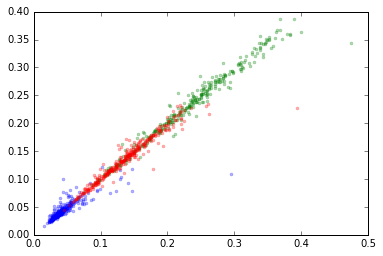

In [66]:
print y_hat.shape, dataset['refl'].shape
plt.plot(dataset['refl'].T, y_hat.T, '.', alpha=0.3)
plt.show()

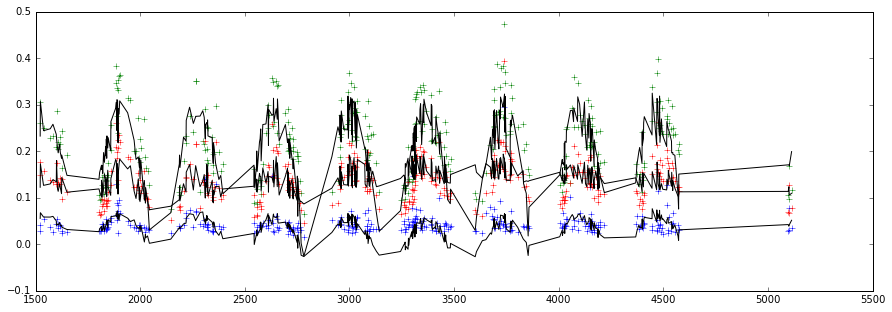

In [16]:
plt.figure(figsize=(15,5))
plt.plot(dataset['idoy'], dataset['refl'].T, '+')
plt.plot(dataset['idoy'], y_hat.T, 'k-')
plt.show()

In [ ]:
"""
fig = plt.figure(figsize=(15,40))
n = 12
for i, gamma_day in enumerate(np.logspace(0, 12, n)):
    x = compute_state_vector(dataset, gamma_day, 0.0) # gamma_year is not used yet
    y_hat = compute_y_hat(dataset, x)
    
    ax = fig.add_subplot(n, 1, i+1)
    ax.plot(dataset['idoy'], dataset['refl'].T, '+')
    ax.plot(dataset['idoy'], y_hat.T, '-')
    ax.set_ylim((0,0.5))
    ax.set_title(gamma_day)
    
plt.show()
"""

# hmmm... A note with regard to the cell below: For some reason, I had to multiply the post_cov matrix by a factor of 100 to get confidence bounds (+/- 1 sigma) that appear to be within a range that could be considered realistic. In other words, the values in post_cov seem *very* small...

/home/martin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


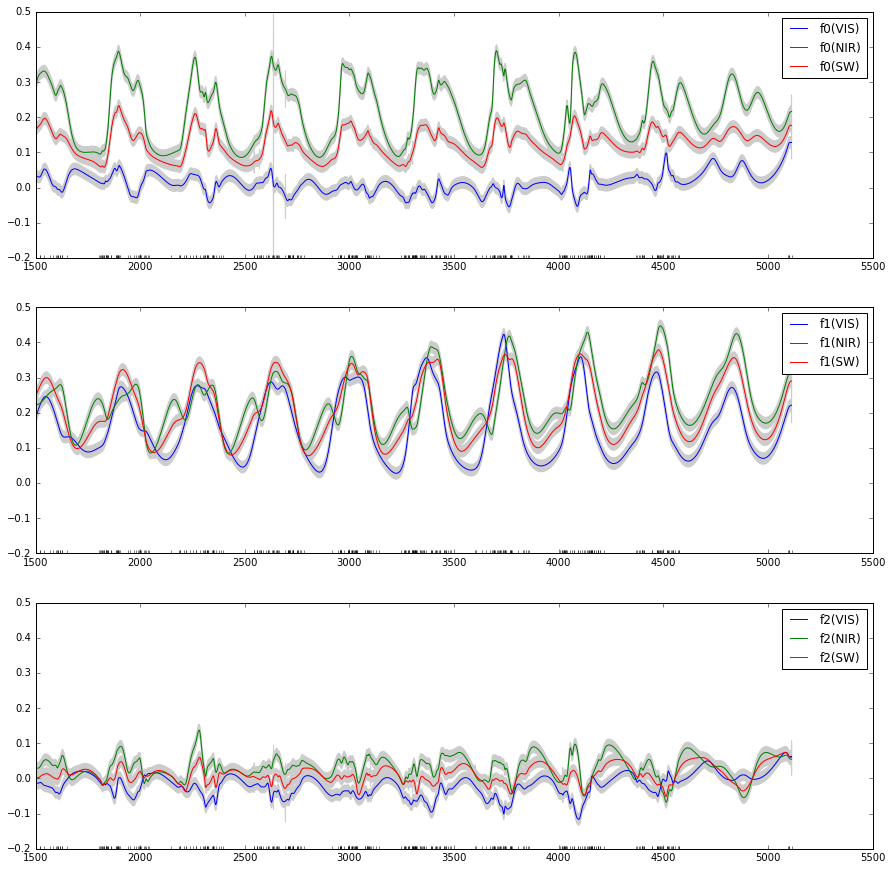

In [17]:
x, post_cov = compute_state_vector(dataset, 1.0E+3, 0.01, ignore_weight=False, do_unc=True)
plot_state_vector(dataset, x, xmin=1500, xmax=5500, ymin=-0.2, ymax=0.5, post_cov=post_cov*100.0)
plt.show()

# Functions to pool and subset datasets

In [13]:
def sort_idoy(dataset):
    e = np.argsort(dataset['idoy'])
    dataset['idoy'] = dataset['idoy'][e]
    dataset['date'] = dataset['date'][e]
    dataset['kernels'] = dataset['kernels'][...,e]
    dataset['weight'] = dataset['weight'][...,e]
    dataset['refl'] = dataset['refl'][...,e]
    if 'source' in dataset.keys():
        dataset['source'] = dataset['source'][e]
    return dataset

def get_subset(dataset, IN_IDX):
    subset = {}
    subset['idoy'] = dataset['idoy'][IN_IDX]
    subset['date'] = dataset['date'][IN_IDX]
    subset['kernels'] = dataset['kernels'][...,IN_IDX]
    subset['weight'] = dataset['weight'][...,IN_IDX]
    subset['refl'] = dataset['refl'][...,IN_IDX]
    if 'source' in dataset.keys():
        subset['source'] = dataset['source'][IN_IDX]
    return subset

def pool_datasets(datasets):
    " datasets is a list of dictionaries (version S2.0 for prior and GA, and S3.0 for BBDR) "
    superset = {}
    for i, dataset in enumerate(datasets):
        n_obs = dataset['idoy'].size
        if i == 0:
            superset = copy.copy(dataset)
            superset['source'] = np.ones(n_obs, dtype=int) # points to elements in datasets
        else:
            superset['idoy'] = np.hstack(( superset['idoy'], dataset['idoy'] ))
            superset['date'] = np.hstack(( superset['date'], dataset['date'] ))
            superset['kernels'] = np.dstack(( superset['kernels'], dataset['kernels'] ))
            superset['weight'] = np.dstack(( superset['weight'], dataset['weight'] ))
            superset['refl'] = np.hstack(( superset['refl'], dataset['refl'] ))
            superset['source'] = np.hstack(( superset['source'], np.ones(n_obs, dtype=int)*(i+1) ))  
            # just be aware that following two objects have different/full shape (> n_obs)
            # not using them for the moment!!!
            #superset['doy'] = np.hstack(( superset['doy'], dataset['doy'] ))
            #superset['year'] = np.hstack(( superset['year'], dataset['year'] ))

    # sort w.r.t. idoy/dates
    superset = sort_idoy(superset)
    
    return superset

def subset_to_year_and_reset_idoy(dataset, year):
    bln = np.array([date.year == year for date in dataset['date']], dtype=bool)
    subset = get_subset(dataset, bln)
    subset['idoy'] -= subset['idoy'].min()
    return subset

# Pooling datasets

In [14]:
sensors = ['bbdr.meris', 'mod09', 'myd09']
# it looks like something is wrong with bbdr.vgt
# running with bbdr.vgt only says: matrix is exactly singular
# hence we leaf it out for now.

datasets = [ncdata[sensor] for sensor in sensors]
pooled_dataset = pool_datasets(datasets)

In [15]:
print monotonic(pooled_dataset['idoy'])

True


In [16]:
for sensor in ['bbdr.meris', 'bbdr.vgt', 'mod09', 'myd09']:
    ds = ncdata[sensor]
    print sensor, ds['idoy'][0], ds['date'][0], "   ", ds['idoy'][-1], ds['date'][-1]

bbdr.meris 1522 2002-06-03     5113 2012-04-02
bbdr.vgt 20 1998-04-23     4813 2011-06-07
mod09 696 2000-02-28     6477 2015-12-27
myd09 1558 2002-07-09     6479 2015-12-29


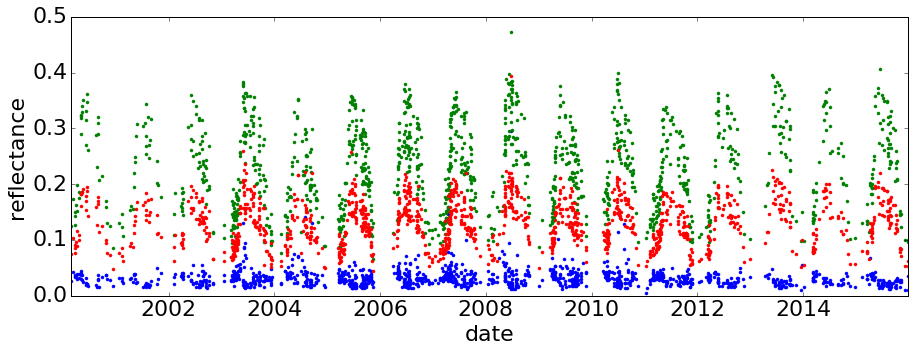

In [22]:
fig = plt.figure( figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(pooled_dataset['date'], pooled_dataset['refl'].T, '.')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_ylabel("reflectance", fontsize=22)
ax.set_xlabel("date", fontsize=22)
plt.show()

# Tuning $\gamma_{day}$ and $\gamma_{year}$

Functions for cross validation and tuning of $\gamma_{day}$ and $\gamma_{year}$. We will run these functions on a subset of the pooled datasets. So, for all sensor products (i.e., bbdr.meris, mod09, myd09, but exclusive of bbdr.vgt due to current problems with this product) we will subset one year worth of data and examine the effect of changing the $\gamma$'s using a cross-validation approach.

In [151]:
def compute_rmse_with_LOO_cv(dataset, gamma_day, gamma_year):
    " Compute state vector with cross validation and return also RMSE "
    nk = dataset['kernels'].shape[0]
    SSE = np.zeros((nk, 1), dtype=float)
    n_obs = dataset['idoy'].size
    n_days = dataset['idoy'][-1]+1
    kf = KFold(n_obs, n_folds=n_obs) # leaf one out
    for train, test in kf:
        trainset = get_subset(dataset, train)
        testset  = get_subset(dataset, test)
        x_train = compute_state_vector(trainset, gamma_day, gamma_year, ndays=n_days)
        y_hat_test = compute_y_hat(testset, x_train)
        SSE += (testset['refl'] - y_hat_test)**2
    MSE = SSE / n_obs
    RMSE = np.sqrt(MSE)
    RMSE = RMSE.reshape((3,)) # reshape to 1d array (instead of (3,1)
    return RMSE

def compute_rmse_per_sensor_cv(dataset, gamma_day, gamma_year):
    assert 'source' in dataset.keys()
    sources = np.unique(dataset['source']) # e.g. references to different sensors or products
    ndays = dataset['idoy'][-1]+1
    SSE = np.zeros(3, dtype=float)
    for source in sources:
        bln = dataset['source'] == source
        testset = get_subset(dataset, bln)
        trainset = get_subset(dataset, ~bln)
        x = compute_state_vector(trainset, gamma_day, gamma_year, ndays=ndays)
        y_hat = compute_y_hat(testset, x)
        residual = testset['refl'] - y_hat
        SSE += (residual**2).sum(axis=-1)
    MSE = SSE/float(len(sources))
    RMSE = np.sqrt(MSE)
    return RMSE

def shift_gamma_with_LOO_cv(dataset, gammas_day=np.logspace(5, 11, 15), \
                gammas_year=np.logspace(1, 8, 15)):
    " Compute the state vector and y_hat for a range of different gamma's "
    surface = []
    for gamma_day in gammas_day:
        for gamma_year in gammas_year:
            rmse = compute_rmse_with_LOO_cv(dataset, gamma_day, gamma_year)
            result = (gamma_day, gamma_year, rmse[0], rmse[1], rmse[2])
            print "%6.2E %6.2E %6.2E %6.2E %6.2E" % result
            surface.append(result)
        print "_" * 45
    surface = np.array(surface)
    return surface

def shift_gamma_per_sensor_cv(dataset, gammas_day=np.logspace(5, 11, 15), \
                gammas_year=[1]): #np.logspace(1, 8, 15)):
    " Compute the state vector and y_hat for a range of different gamma's "
    surface = []
    for gamma_day in gammas_day:
        for gamma_year in gammas_year:
            rmse = compute_rmse_per_sensor_cv(dataset, gamma_day, gamma_year)
            result = (gamma_day, gamma_year, rmse[0], rmse[1], rmse[2])
            print "%6.2E %6.2E %6.2E %6.2E %6.2E" % result            
            surface.append(result)
        print "_" * 45
    surface = np.array(surface)
    return surface

In [152]:
# reduce number of observations down to something managable for Leaf One Out Cross Validation (LOOCV)
subset = subset_to_year_and_reset_idoy(pooled_dataset, 2005)
print 'from', pooled_dataset['idoy'].size, 'days, down to', subset['idoy'].size
print subset['idoy'].min(), subset['idoy'].max()
print monotonic(subset['idoy'])

from 1302 days, down to 128
0 240
True


Determine optimal gammas using cross validation, by leaving out one data source (sensor) at a time.

In [173]:
# define here...
dlog0, dlogn = -2, 13
ylog0, ylogn = -20, 5

In [174]:
dn = dlogn - dlog0 + 1
yn = ylogn - ylog0 + 1
rmses = shift_gamma_per_sensor_cv(subset, \
                                  gammas_day=np.logspace(dlog0, dlogn, dn), gammas_year=np.logspace(ylog0, ylogn, yn))

1.00E-02 1.00E-20 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-19 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-18 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-17 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-16 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-15 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-14 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-13 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-12 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-11 3.97E-01 6.47E-01 2.12E-01
1.00E-02 1.00E-10 3.97E-01 6.46E-01 2.12E-01
1.00E-02 1.00E-09 3.96E-01 6.43E-01 2.11E-01
1.00E-02 1.00E-08 3.84E-01 6.17E-01 2.05E-01
1.00E-02 1.00E-07 3.18E-01 5.18E-01 1.87E-01
1.00E-02 1.00E-06 2.14E-01 4.04E-01 1.66E-01
1.00E-02 1.00E-05 1.77E-01 3.80E-01 1.75E-01
1.00E-02 1.00E-04 1.83E-01 3.92E-01 2.03E-01
1.00E-02 1.00E-03 2.10E-01 4.15E-01 2.22E-01
1.00E-02 1.00E-02 2.15E-01 4.05E-01 2.00E-01
1.00E-02 1.00E-01 2.03E-01 3.89E-01 2.04E-01
1.00E-02 1.00E+00 2.07E-01 3.72E-01 2.19E-01
1.00E-02 1.00E+01 2.22E-01 3.46E-01 2.13E-01
1.00E-02 1

In [179]:
print np.unique(rmses[:,0])
print np.unique(rmses[:,1])

[  1.00000000e-02   1.00000000e-01   1.00000000e+00   1.00000000e+01
   1.00000000e+02   1.00000000e+03   1.00000000e+04   1.00000000e+05
   1.00000000e+06   1.00000000e+07   1.00000000e+08   1.00000000e+09
   1.00000000e+10   1.00000000e+11   1.00000000e+12   1.00000000e+13]
[  1.00000000e-20   1.00000000e-19   1.00000000e-18   1.00000000e-17
   1.00000000e-16   1.00000000e-15   1.00000000e-14   1.00000000e-13
   1.00000000e-12   1.00000000e-11   1.00000000e-10   1.00000000e-09
   1.00000000e-08   1.00000000e-07   1.00000000e-06   1.00000000e-05
   1.00000000e-04   1.00000000e-03   1.00000000e-02   1.00000000e-01
   1.00000000e+00   1.00000000e+01   1.00000000e+02   1.00000000e+03
   1.00000000e+04   1.00000000e+05]


In [189]:
dlogn

13

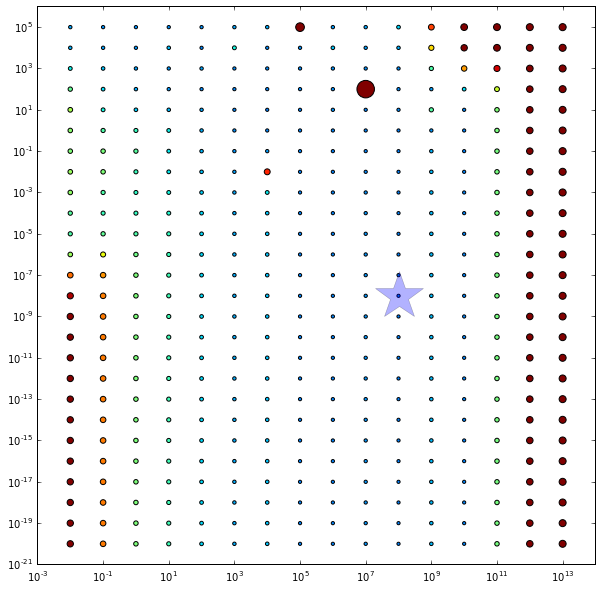

In [191]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(rmses[:,0], rmses[:,1], c=rmses[:,2], s=rmses[:,2]*100, vmin=0.0, vmax=0.4)

e = np.argmin(rmses[:,2])
ax.plot( rmses[e,0], rmses[e,1], '*', ms=50, alpha=0.3)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim((10.0**(dlog0-1), 10.0**(dlogn+1)))
ax.set_ylim((10.0**(ylog0-1), 10.0**(ylogn+1)))
plt.show()

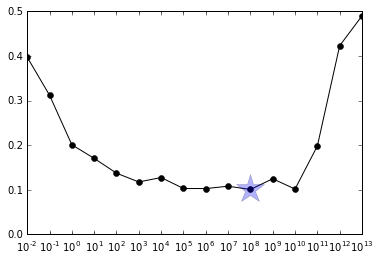

In [192]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rmses[::yn,0], rmses[::yn, 2], 'k-o')
ax.set_ylim((0, 0.5))
ax.set_xscale('log')
ax.plot(rmses[np.argmin(rmses[:,2]),0], rmses[np.argmin(rmses[:,2]),2], '*', ms=30, alpha=0.3)
plt.show()

26


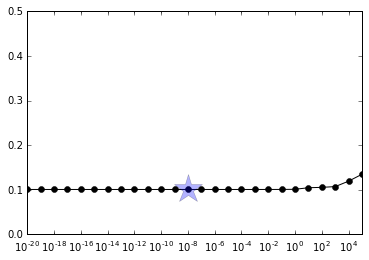

In [194]:
fig = plt.figure()
ax = fig.add_subplot(111)
bln = rmses[:,0] == rmses[np.argmin(rmses[:,2]),0]
print bln.sum()
ax.plot(rmses[bln,1], rmses[bln, 2], 'k-o')
ax.plot(rmses[np.argmin(rmses[:,2]),1], rmses[np.argmin(rmses[:,2]),2], '*', ms=30, alpha=0.3)
ax.set_ylim((0.0, 0.5))
ax.set_xscale('log')
plt.show()

Determine optimal gammas using Leaf One Out Cross Validation (LOOCV).

In [198]:
rmses = shift_gamma_with_LOO_cv(subset, \
                                gammas_day=np.logspace(0, 10, 11), gammas_year=np.logspace(-10, 10, 21))

1.00E+00 1.00E-10 4.03E-02 7.90E-02 2.56E-02
1.00E+00 1.00E-09 4.03E-02 7.90E-02 2.56E-02
1.00E+00 1.00E-08 4.03E-02 7.90E-02 2.56E-02
1.00E+00 1.00E-07 4.02E-02 7.89E-02 2.56E-02
1.00E+00 1.00E-06 3.99E-02 7.76E-02 2.52E-02
1.00E+00 1.00E-05 3.78E-02 6.92E-02 2.30E-02
1.00E+00 1.00E-04 3.32E-02 5.25E-02 2.12E-02
1.00E+00 1.00E-03 2.91E-02 4.39E-02 2.36E-02
1.00E+00 1.00E-02 2.77E-02 4.64E-02 2.55E-02
1.00E+00 1.00E-01 2.49E-02 5.29E-02 2.70E-02
1.00E+00 1.00E+00 2.12E-02 4.88E-02 2.56E-02
1.00E+00 1.00E+01 1.94E-02 4.23E-02 2.29E-02
1.00E+00 1.00E+02 1.87E-02 3.92E-02 2.11E-02
1.00E+00 1.00E+03 1.81E-02 4.06E-02 2.17E-02
1.00E+00 1.00E+04 1.68E-02 4.33E-02 2.28E-02
1.00E+00 1.00E+05 1.66E-02 4.40E-02 2.30E-02
1.00E+00 1.00E+06 1.71E-02 4.41E-02 2.43E-02
1.00E+00 1.00E+07 1.62E-02 4.64E-02 2.49E-02
1.00E+00 1.00E+08 1.76E-02 5.19E-02 2.84E-02
1.00E+00 1.00E+09 1.62E-02 5.49E-02 2.99E-02
1.00E+00 1.00E+10 1.67E-02 5.46E-02 2.85E-02
_____________________________________________
1.00E+01 

In [199]:
rmses_fine = shift_gamma_with_LOO_cv(subset, \
                                gammas_day=np.logspace(5, 7, 21), gammas_year=np.logspace(-2, -1, 11))

1.00E+05 1.00E-02 1.59E-02 1.76E-02 1.18E-02
1.00E+05 1.26E-02 1.59E-02 1.76E-02 1.18E-02
1.00E+05 1.58E-02 1.59E-02 1.76E-02 1.18E-02
1.00E+05 2.00E-02 1.59E-02 1.77E-02 1.18E-02
1.00E+05 2.51E-02 1.59E-02 1.77E-02 1.18E-02
1.00E+05 3.16E-02 1.59E-02 1.77E-02 1.18E-02
1.00E+05 3.98E-02 1.59E-02 1.77E-02 1.18E-02
1.00E+05 5.01E-02 1.59E-02 1.77E-02 1.18E-02
1.00E+05 6.31E-02 1.59E-02 1.77E-02 1.18E-02
1.00E+05 7.94E-02 1.59E-02 1.77E-02 1.18E-02
1.00E+05 1.00E-01 1.59E-02 1.78E-02 1.19E-02
_____________________________________________
1.26E+05 1.00E-02 1.60E-02 1.76E-02 1.17E-02
1.26E+05 1.26E-02 1.60E-02 1.76E-02 1.17E-02
1.26E+05 1.58E-02 1.60E-02 1.76E-02 1.17E-02
1.26E+05 2.00E-02 1.60E-02 1.76E-02 1.17E-02
1.26E+05 2.51E-02 1.60E-02 1.76E-02 1.17E-02
1.26E+05 3.16E-02 1.60E-02 1.76E-02 1.18E-02
1.26E+05 3.98E-02 1.60E-02 1.76E-02 1.18E-02
1.26E+05 5.01E-02 1.60E-02 1.76E-02 1.18E-02
1.26E+05 6.31E-02 1.60E-02 1.77E-02 1.18E-02
1.26E+05 7.94E-02 1.60E-02 1.77E-02 1.18E-02
1.26E+05 

In [ ]:
# Do again, now using the pooled dataset
dlog0, dlogn = 5, 8
ylog0, ylogn = 0, 8
dn = dlogn - dlog0 + 1
yn = ylogn - ylog0 + 1
rmses = shift_gamma_per_sensor_cv(pooled_dataset, \
                                  gammas_day=np.logspace(dlog0, dlogn, dn), gammas_year=np.logspace(ylog0, ylogn, yn))

# NEXT: Examine and plot the rmses and rmses_fine arrays from the previous two cells using plotting commands from cells before.

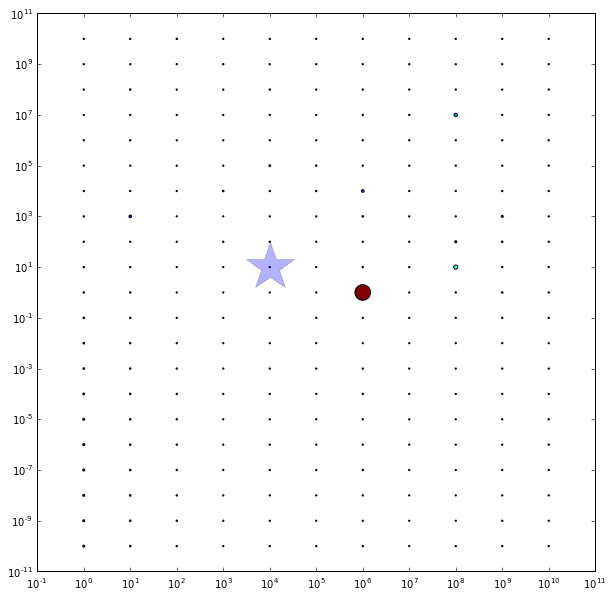

In [200]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(rmses[:,0], rmses[:,1], c=rmses[:,2], s=rmses[:,2]*100, vmin=0.0, vmax=0.4)

e = np.argmin(rmses[:,2])
ax.plot( rmses[e,0], rmses[e,1], '*', ms=50, alpha=0.3)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim((10.0**-1, 10.0**11))
ax.set_ylim((10.0**-11, 10.0**11))
plt.show()

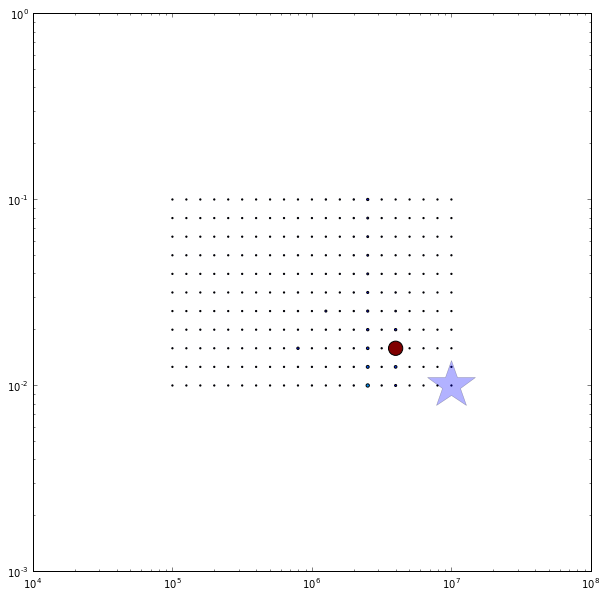

In [201]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(rmses_fine[:,0], rmses_fine[:,1], c=rmses_fine[:,2], s=rmses_fine[:,2]*100, vmin=0.0, vmax=0.4)

e = np.argmin(rmses_fine[:,2])
ax.plot( rmses_fine[e,0], rmses_fine[e,1], '*', ms=50, alpha=0.3)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim((10.0**4, 10.0**8))
ax.set_ylim((10.0**(-3), 10.0**0))
plt.show()

# THEN: compute best-fit state vector for 15 years worth of data

/home/martin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


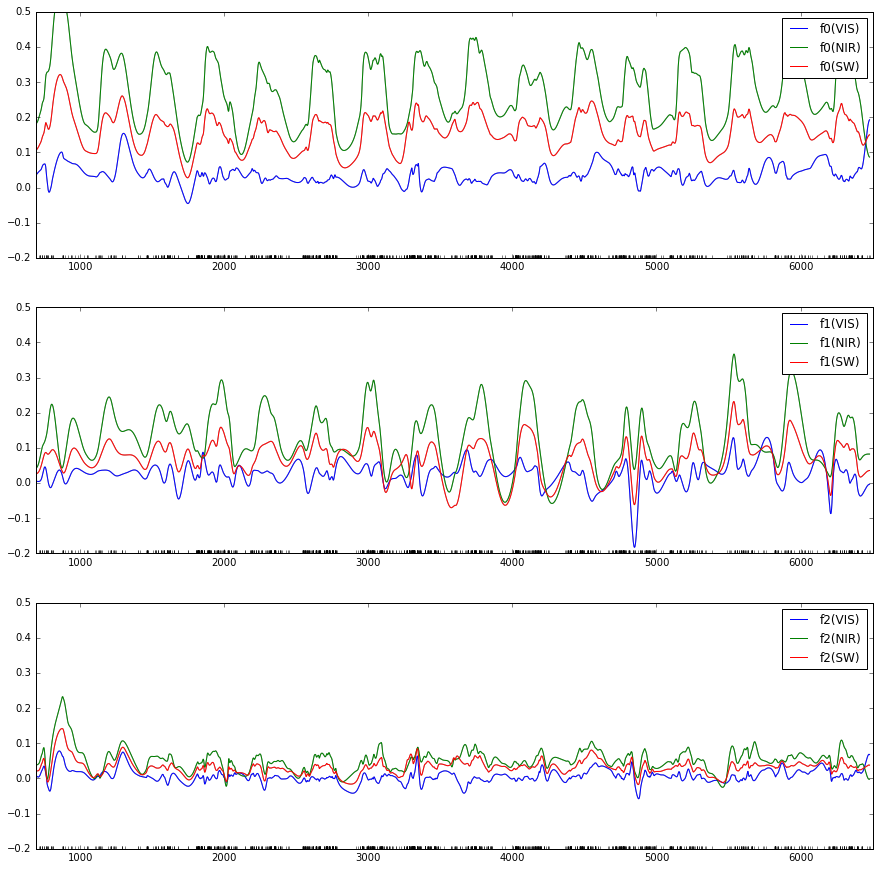

In [203]:
#x, post_cov = compute_state_vector(pooled_dataset, 1.0E+5, 1.0E-2, ignore_weight=False, do_unc=True)
plot_state_vector(pooled_dataset, x, xmin=690, xmax=6500, ymin=-0.2, ymax=0.5, post_cov=post_cov*100.0)
plt.show()